# Comparing LSA, LDA, and NNMF
#Now that you've been introduced to the logic behind these three topic extraction methods, 
#we're going to try them out on the Emma corpus. We'll be looking at interpretability, 
#speed, and consistency across methods. The goal is to identify common themes in Emma on a 
#per-paragraph basis. We won't be using pLSA as sklearn does not support it.

In [ ]:
#To do this, we will:
#Parse and process the data into a tf-idf matrix.
#Fit LSA, LDA, and NNMF models with 5 topics each.
#Extract the words that best describe each topic.
#Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Generating the tfidf matrix

In [2]:
# Processing the data.

from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10



# Fitting the three topic extraction models

In [13]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)
#print("emma paras lsa is:",emma_paras_lsa)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)
#print(components_lsa)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)                



In [4]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf) 

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)



/Users/karenmcgee/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [5]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf) 

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

# Inspecting the topics

In [6]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
               LSA            LDA             NNMF
0         oh 97.61      emma 13.3         oh 30.12
0         yes 4.79  harriet 12.73         yes 0.52
0  difference 1.57        mr 11.6       sorry 0.16
0        just 1.43      said 10.2  difference 0.15
0     harriet 1.34        oh 9.99        just 0.12
0       thank 1.31     think 9.48        papa 0.12
0       sorry 1.28       mrs 9.13        week 0.11
0       short 1.17   chapter 8.69       short 0.11
0        papa 1.15     quite 7.79    recollect 0.1
0       cried 1.02      miss 7.12      letter 0.09
Topic 1:
             LSA           LDA            NNMF
1      emma 58.4      oh 58.31         mr 7.29
1       mr 58.01     emma 19.1        mrs 4.26
1     said 49.95    said 14.64      elton 3.41
1      mrs 47.08     mrs 14.23  knightley 3.24
1     miss 37.59      mr 14.19     weston 3.15
1  harriet 35.44     yes 13.91       miss 2.99
1   weston 32.24     did 10.73  woodhouse 2.09
1    elton 27.83     miss 9.52       said 1.8

In [ ]:
#A number of things are clear. First, some topics are shared, though the order of 
#topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA. And 
#second, the content of some of the topics varies considerably across methods. This is 
#a clear argument for using multiple methods when exploring topics.

In [ ]:
#Sparsity
#Now let's examine sparsity by looking at the distributions of loadings for the words 
#'marriage', 'love', 'emma', and 'oh' across the methods:

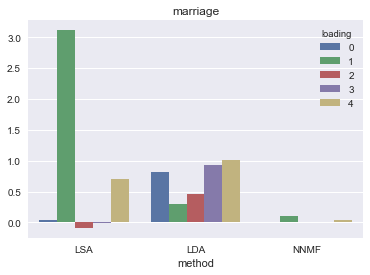

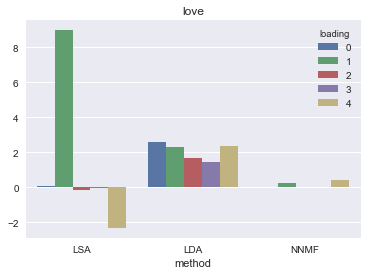

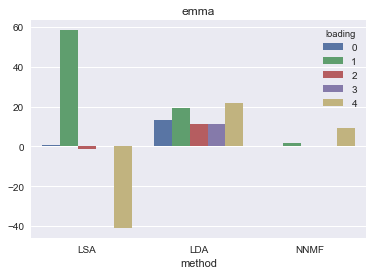

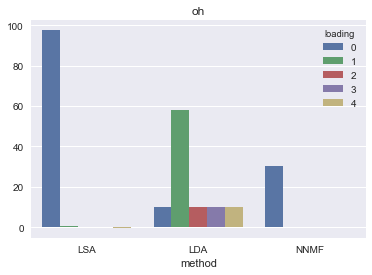

In [7]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


In [ ]:
#LSA is the method most likely to have high loadings on more than one topic for the 
#same word. LDA tends to have one high loading and some lower loadings. Loadings 
#for NNMF are lower all around, and the most sparse, with some of the topics having 
#loadings of zero on each word.

# Challenge: Topic extraction on new data

In [ ]:
#Take the well-known 20 newsgroups dataset and use each of the methods on it. 
#Your goal is to determine which method, if any, best reproduces the topics 
#represented by the newsgroups. Write up a report where you evaluate each method in 
#light of the 'ground truth'- the known source of each newsgroup post. Which works best, 
#and why do you think this is the case?

In [93]:
from sklearn.datasets import fetch_20newsgroups
#newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = newsgroups.data

In [94]:
news_df = pd.DataFrame({'document':documents})

# removing everything except alphabets`
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [95]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# tokenization
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

In [97]:
# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words='english')
newsgroups_tfidf=vectorizer.fit_transform(news_df['clean_doc'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Number of topics.
ntopics=5

newsgroups_tfidf.shape

(11314, 64741)

In [100]:
#LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
newsgroups_lsa = lsa.fit_transform(newsgroups_tfidf)
#print("emma paras lsa is:",emma_paras_lsa)

newsgroups_components_lsa = word_topic(newsgroups_tfidf, newsgroups_lsa, terms)
#print(components_lsa)

topwords=pd.DataFrame()
topwords['LSA']=top_words(newsgroups_components_lsa, n_top_words)                



In [102]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_topics=ntopics, 
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

newsgroups_lda = lda.fit_transform(newsgroups_tfidf) 

components_lda = word_topic(newsgroups_tfidf, newsgroups_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)




/Users/karenmcgee/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [103]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
newsgroups_nmf = nmf.fit_transform(newsgroups_tfidf) 

components_nmf = word_topic(newsgroups_tfidf, newsgroups_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

In [104]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])

Topic 0:
             LSA            LDA          NNMF
0    like 131.03     know 94.63   people 5.63
0    know 125.35     like 92.69    think 3.95
0  people 105.13   people 84.55      like 3.6
0   think 104.13    think 83.28     know 3.41
0      good 89.4     good 71.42     time 2.67
0      time 87.6     time 70.12     good 2.56
0    thanks 78.0   thanks 64.65  believe 2.36
0     want 68.76    drive 58.24    right 2.31
0     make 68.04     card 52.93     jesus 2.3
0     need 68.02  windows 52.59     make 2.13
Topic 1:
              LSA              LDA          NNMF
1    thanks 54.27        pitt 7.48  windows 6.93
1   windows 50.62        know 7.46    thanks 6.0
1      card 40.77      gordon 7.34      know 4.1
1     drive 29.08        like 7.18     card 3.72
1      file 26.45       cadre 7.16     file 3.59
1       mail 25.1    chastity 7.14     mail 3.08
1     video 23.04    shameful 7.12     like 2.98
1  software 22.81   intellect 7.09    files 2.79
1    advance 21.3  skepticism 7.07 

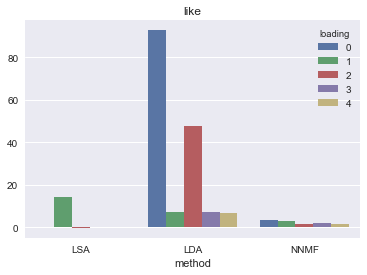

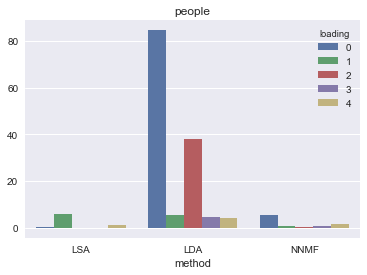

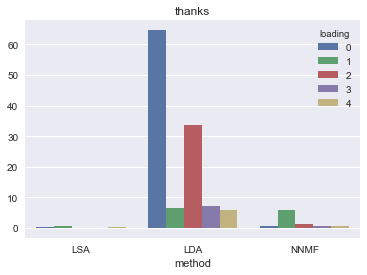

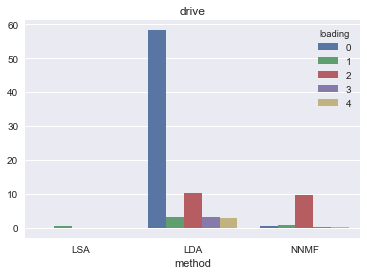

In [108]:
# The words to look at.
targetwords=['like','people','thanks','drive']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes. 
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()



# Overall it appears LDA is performing better than LSA and NNMF.